In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Create Sample Time Series

In [2]:
time_index = pd.date_range(start='2022-01-01', periods=100, freq='D')
trend = 0.5 * np.arange(100)
seasonality = 10 * np.sin(np.arange(100) * (2 * np.pi / 12))
noise = np.random.normal(1, 1, 100)
data = trend + seasonality + noise
sample_ts_df = pd.DataFrame({'Date': time_index, 'Value': data})
sample_ts_df.set_index('Date', inplace=True)

<h1> <span style="color:red;"> Step 1:- EDA</span></h1>

Here in this sample project we will do few important visualization steps to understand our timeseries. We can use this notebook as future reference or template for real time series data.

In [3]:
custom_colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'lightpink']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors) #for matplotlib
sns.set_palette(custom_colors) #for seaborn

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;1. Basic Visualization using Histogram and Boxplot </span></h2> This will provide an overview of the data's behaviour.

In [4]:
sample_ts_df.describe()

,Value
count,100.000000
mean,25.900725
std,16.063511
min,-5.447906
25%,12.616699
50%,25.543719
75%,38.246046
max,61.483730


👆 This information is really useful. For example, weather forecasters can use it to figure out the average, lowest, and highest temperatures for a month.

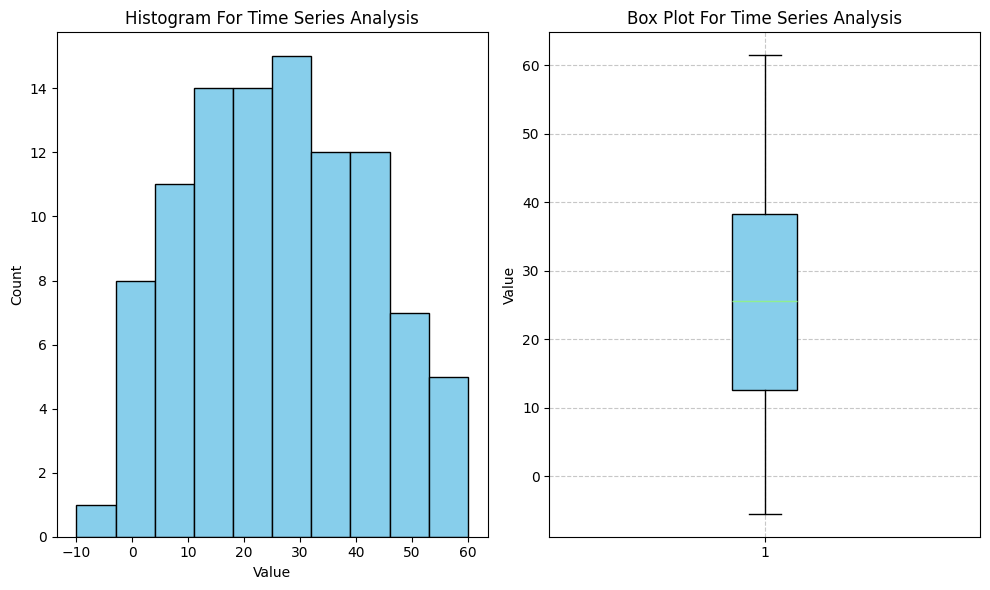

In [5]:
fig,ax=plt.subplots(1,2, figsize=(10,6))

bins = 10
range = (-10,60)
ax[0].hist(sample_ts_df['Value'], bins=bins, range=range, edgecolor='black')
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram For Time Series Analysis")

ax[1].boxplot(sample_ts_df['Value'], patch_artist=True)
ax[1].set_title("Box Plot For Time Series Analysis")
ax[1].set_ylabel("Value")
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> 1. The histogram shows us which number appears the most often. It also shows if there are groups of numbers close together (aka presence of clusters). In our case, most of the numbers are between 20 and 30.<br> 2. The box plot shows us that there are outliers in the data.

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;2. Time Series Plot </span></h2> By checking time series plot we can get basic understanding of <b>trends</b> (<i>going up or down</i>), <b>patterns</b> (<i>regular ups and downs</i>), anything <b>unusual</b> (<i>anomalies</i>) etc.

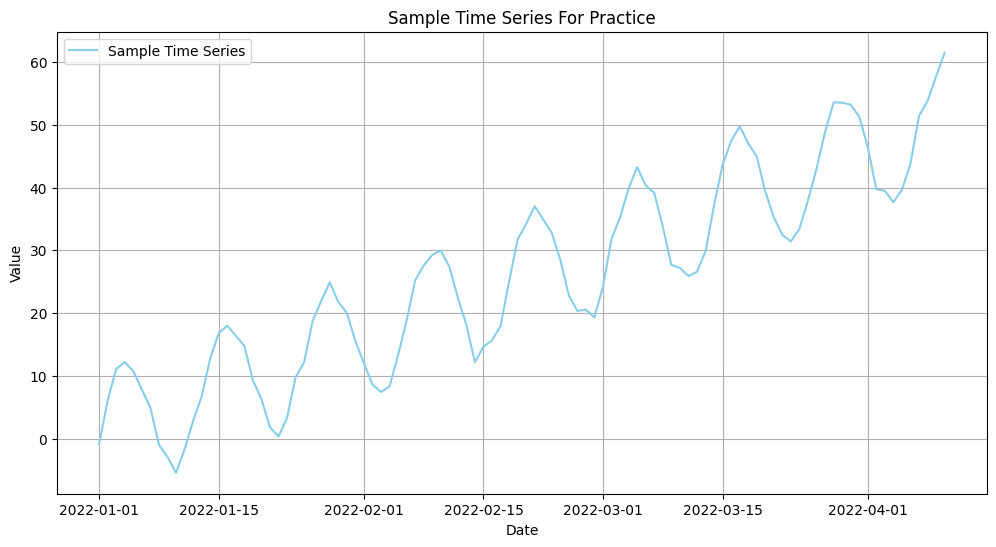

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(sample_ts_df.index, sample_ts_df['Value'], label='Sample Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)
plt.show()

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> We can observe some trend and pattern in this data, lets try to decompose the timeseries to understand it better.

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;3. Decomposition: </span></h2> We can decompose a time series into its <b>trend</b>, <b>seasonal</b>, and <b>residual components</b> using techniques like <i><span style="color:brown;">additive</span></i>, <i><span style="color:brown;">multiplicative</span></i>, or <i><span style="color:brown;">STL </span></i>decomposition.<br><h3>Which Decomposition method to choose?</h3>
<ul>
    <li>Additive decomposition: When the seasonal fluctuations remain relatively constant across different levels of the time series,</li> 
    <li>Multiplicative decomposition: When the seasonal fluctuations increase or decrease in proportion to the overall level of the time series.</li>
    <li>STL: When the seasonal patterns in the time series data are complex or non-linear, or when there are irregularities that traditional additive or multiplicative decomposition methods may not capture effectively.</li>
</ul>

As <span style="color:red;"><b> STL </b></span> is a robust decomposition method which can handle various types of time series data we will use it for our time series. <br><br><b>Remember:</b><br>
    1. Both Additive and Multiplicative Decomposition uses same method <span style="color:skyblue;">from statsmodels.tsa.seasonal import seasonal_decompose</span>. "model" parameter distinguish which method to use. <br>
    2. We cannot use Multiplicative Decomposition for zero and negative values. <br>
    3. STL Decomposition method expects a series like object. That is why we either need to convert our dataframe into a series or mention only one column.<br>
    4. The "seasonal" parameter value in STL is very important so we have to choose it carefully. The value must be odd and larger than season. If we are not sure about the number, we can start with the default value (7) and experiment with slightly higher odd values (e.g., 9, 11, 13..). A higher season value captures smoother seasonal patterns but might miss out on finer details and a lower season value might capture more details but could also introduce noise into the seasonal component.
It's often recommended to keep season less than half the length of our data to avoid overfitting the seasonal component.<br><br>

In [7]:
#Let's turn this into a function since we'll use it again
def plot_timeseries_decompositon(df):
    result_stl = STL(df, seasonal=9).fit()
    stl_trend = result_stl.trend
    stl_seasonal = result_stl.seasonal
    stl_residual = result_stl.resid

    fig, axs = plt.subplots(4, 1, figsize=(12,8), sharex=True)

    axs[0].plot(df, label='Original')
    axs[0].set_title('Original Time Series')
    axs[0].legend(loc='upper left')

    axs[1].plot(stl_trend, color='green', label='Trend')
    axs[1].set_title('Trend Component')
    axs[1].legend(loc='upper left')

    axs[2].plot(stl_seasonal, color='red', label='Seasonal')
    axs[2].set_title('Seasonal Component')
    axs[2].legend(loc='upper left')

    axs[3].plot(stl_residual, color='purple', label='Noise')
    axs[3].set_title('Residuals Component')
    axs[3].legend(loc='upper left')
    
    plt.show()

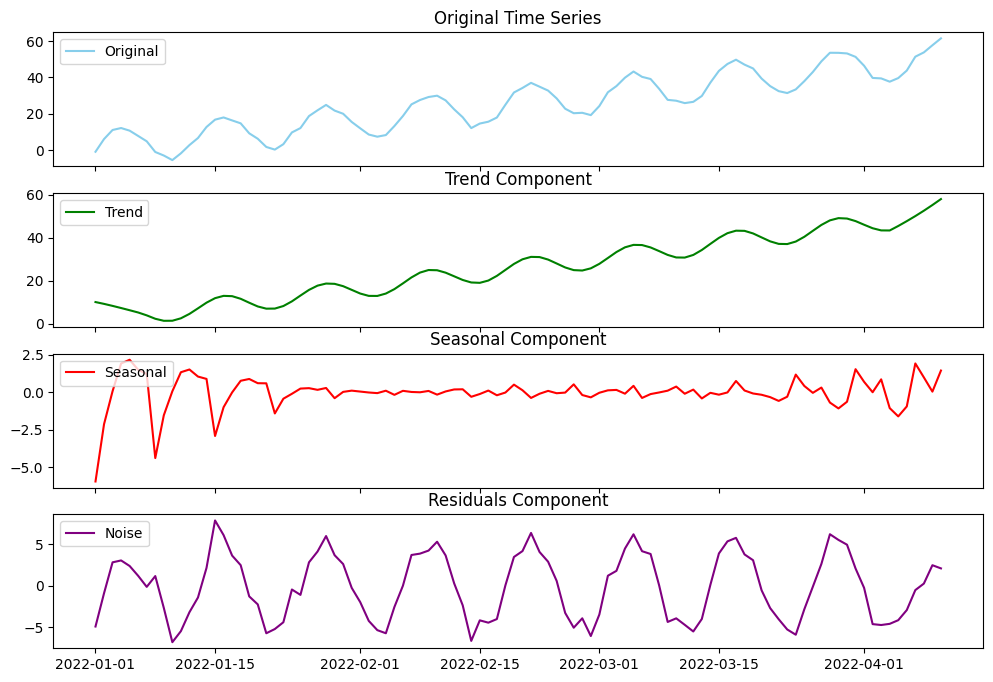

In [8]:
plot_timeseries_decompositon(sample_ts_df['Value'])

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> 1. We can see intially seasonal component was large, rduced over time and then started increasing again, it indicates a more complex seasonal pattern theat evolves over time.<br>2. Forecasting: To forecast we will try two things. First, we will remove trend, seasonality and residuals to check how new timeseries perform and also We will try to use the individual components to make predictions about future values of our time series and observe how will that work. Only the modified time series is stationary.<br>3. Now we have some understanding of all the different components of our time series so lets try to understand different statistics of our timeseries and how much stationary is our timeseries.<br>

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;4. Rolling Statistics: </span></h2>We use the rolling() function on the time series data to calculate the rolling mean and rolling standard deviation over a window of size window_size.
We then plot the original time series data along with the rolling mean and rolling standard deviation for visualization.
Adjust the window_size parameter based on the frequency and characteristics of your time series data. Larger window sizes result in smoother rolling statistics but may obscure short-term patterns. Experiment with different window sizes to find the one that best suits your analysis requirements.

The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).

In [9]:
def plot_rolling_statistics(df,y_axis_label):
    rolling_mean = df.rolling(window=9).mean()
    rolling_std = df.rolling(window=9).std()

    plt.figure(figsize=(10, 6))
    plt.plot(df, label='Time Series')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.title('Time Series Data with Rolling Statistics')
    plt.xlabel('Date')
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.grid(True)
    plt.show()

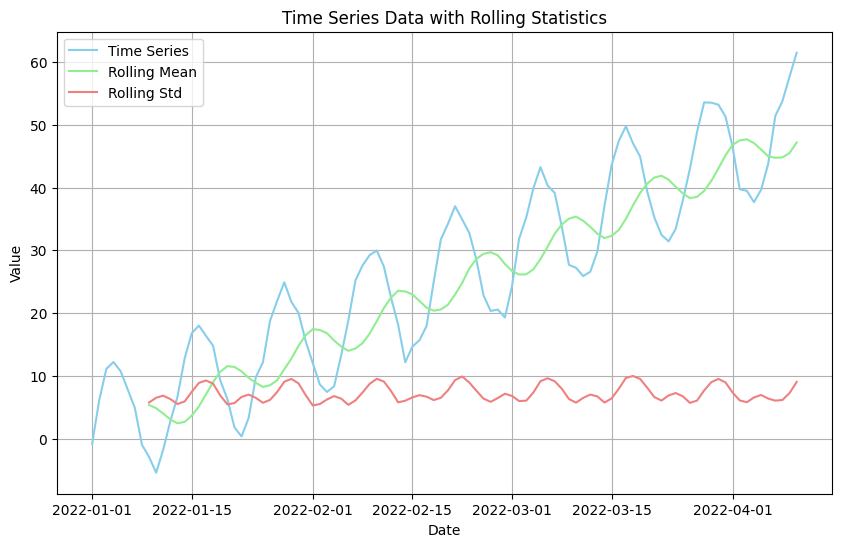

In [10]:
plot_rolling_statistics(sample_ts_df['Value'],'Value')

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> 1.<br>

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;5. ADF: </span></h2> If a time series is stationary and has a particular behaviour over a given time interval, then it is safe to assume that it will have same behaviour at some later point in time. Most statistical modelling methods assume or require the time series to be stationary.

ADF statistic value measures how strong the evidence is against stationarity (negative values favor stationarity). If the ADF statistic is more negative than the absolute value of the critical value at any of the significance levels (1%, 5%, or 10%), you can reject the null hypothesis (non-stationarity) and conclude that the time series is likely stationary. While a lower ADF statistic (more negative) strengthens the evidence for stationarity, it's crucial to compare it to the critical values at the chosen significance level for a definitive conclusion.

In [11]:
def timeseries_stationary_check_using_ADF(df):
    result = adfuller(df)

    adf_statistic = result[0]
    p_value = result[1]

    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')  
    for key, value in result[4].items():  
        print('\t{}: {}'.format(key, value)) 

In [12]:
timeseries_stationary_check_using_ADF(sample_ts_df['Value']) 

ADF Statistic: 0.6981557260510587
p-value: 0.989800992013182
Critical Values:
	1%: -3.5078527246648834
	5%: -2.895382030636155
	10%: -2.584823877658872


<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Observation: </span></h3> 1.<br>

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;6. ACF and PACF: </span></h2>

In [13]:
def plot_ACF_PACF(df,acf_lags,pacf_lags):
    plt.figure(figsize=(12, 6))
    plot_acf(df, lags=acf_lags, ax=plt.gca()) #maximum total values-1
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

    plt.figure(figsize=(12, 6))
    plot_pacf(df, lags=pacf_lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)') #maximum will be ACF/2
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()

Lets make this time series stationary

In [15]:
sample_ts_df['Detrended'] = sample_ts_df['Value']-sample_ts_df['Value'].shift(1)

In [16]:
sample_ts_df['Detrended'].isnull().sum() # null values will cause problem calculating ADF so check and remove those

1

In [17]:
sample_ts_df.dropna(inplace=True)

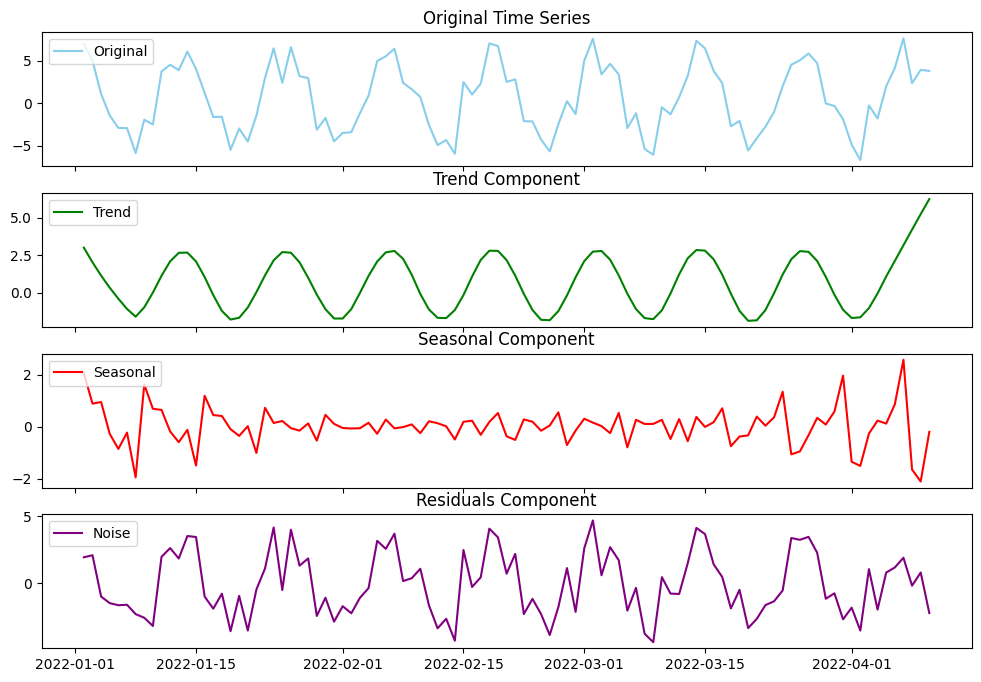

In [18]:
plot_timeseries_decompositon(sample_ts_df['Detrended'])

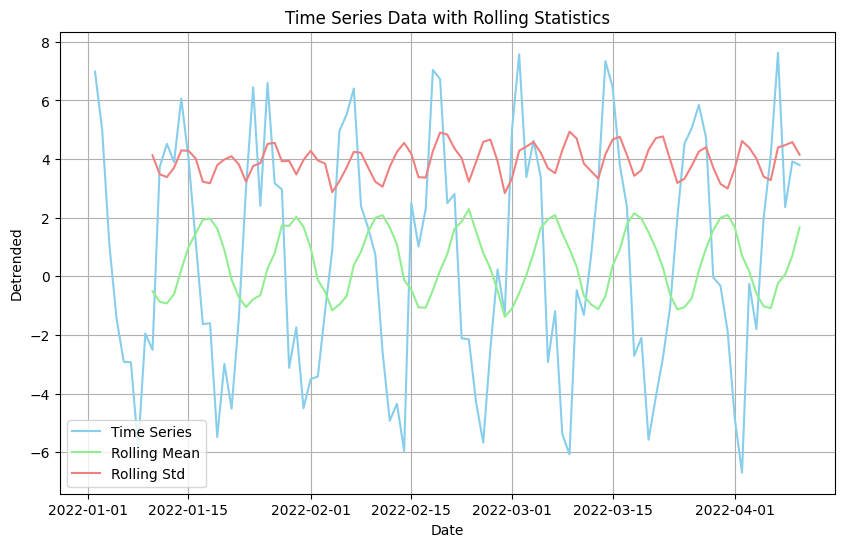

In [19]:
plot_rolling_statistics(sample_ts_df['Detrended'],'Detrended')

In [20]:
timeseries_stationary_check_using_ADF(sample_ts_df['Detrended']) 

ADF Statistic: -7.334485381739343
p-value: 1.1057025206735327e-10
Critical Values:
	1%: -3.5087828609430614
	5%: -2.895783561573195
	10%: -2.5850381719848565


We can see our data is now stationary so we can apply time series models like ARIMA. But before applying lets check how it will perform if we remove seasonality and residuals.

In [35]:
monthly_means = sample_ts_df.groupby(sample_ts_df.index.month).mean()

In [41]:
sample_ts_df['Deseasonalized'] = sample_ts_df['Detrended'] - monthly_means.loc[sample_ts_df.index.month]['Detrended'].values
sample_ts_df['Smoothed']=sample_ts_df['Deseasonalized'].rolling(window=7).mean()
sample_ts_df.dropna(inplace=True)
sample_ts_df.shape[0]

69

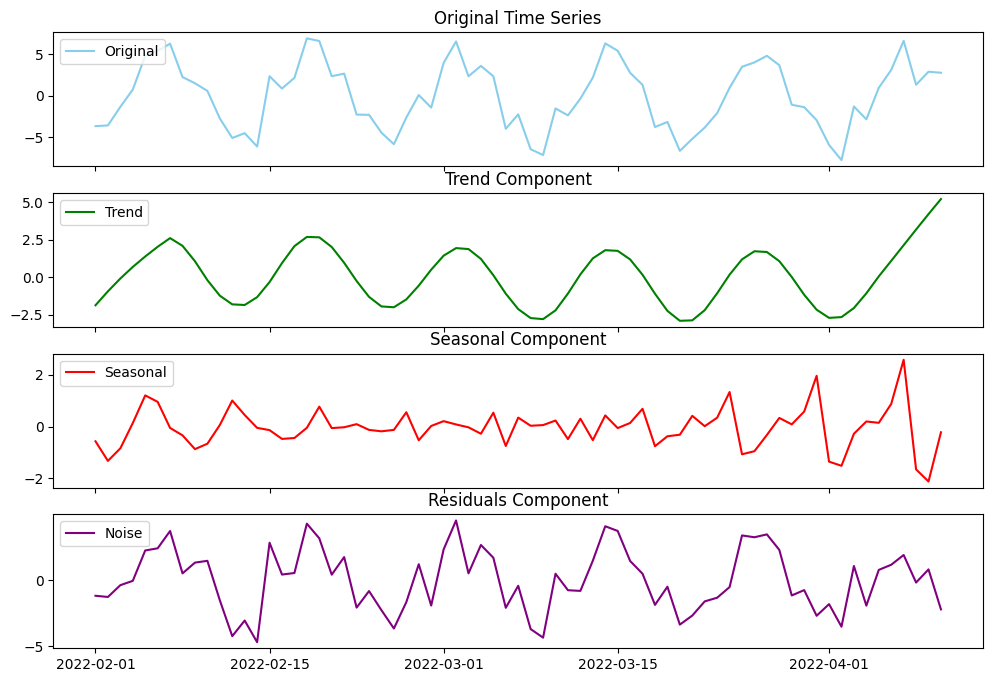

In [42]:
plot_timeseries_decompositon(sample_ts_df['Deseasonalized'])

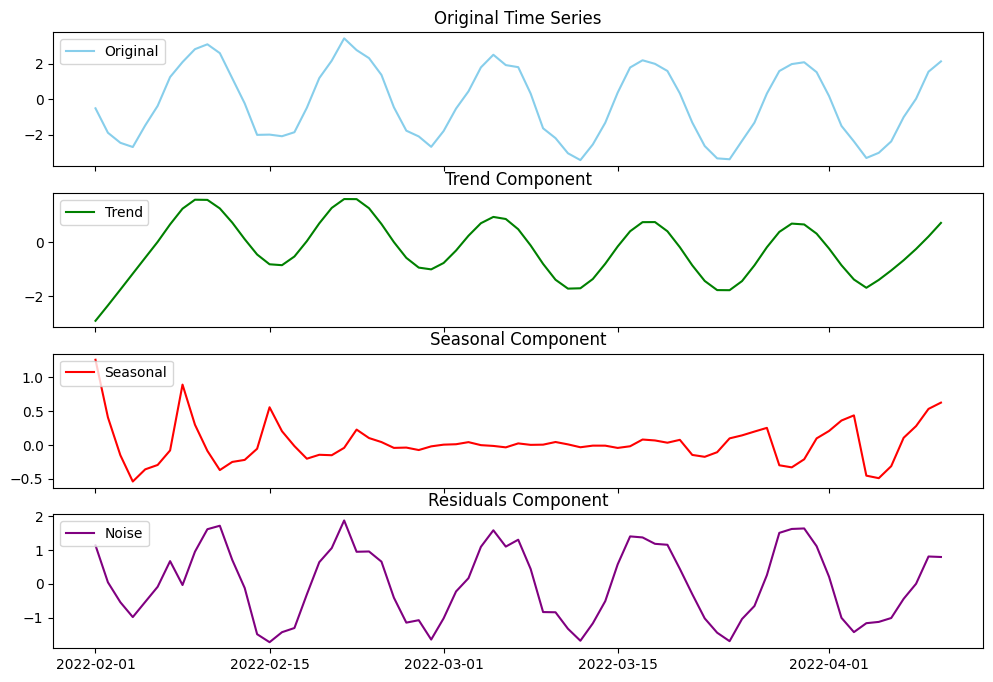

In [43]:
plot_timeseries_decompositon(sample_ts_df['Smoothed'])

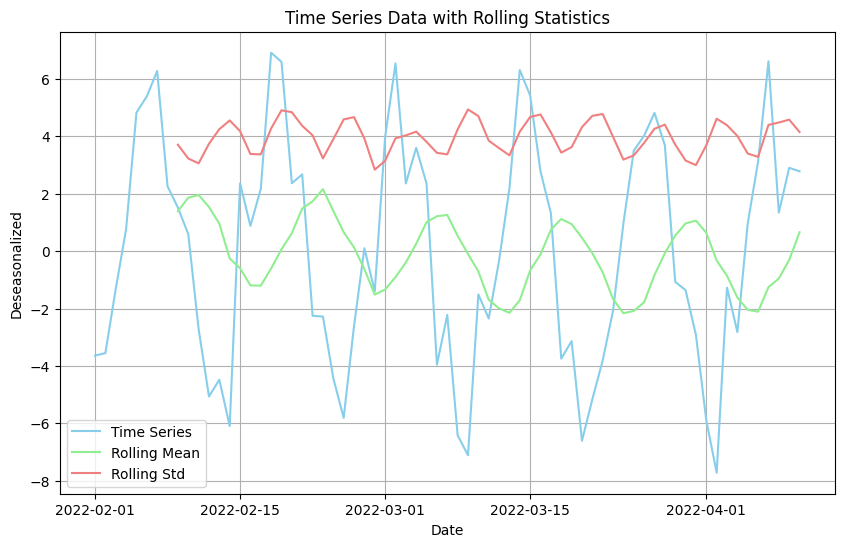

In [45]:
plot_rolling_statistics(sample_ts_df['Deseasonalized'],'Deseasonalized')

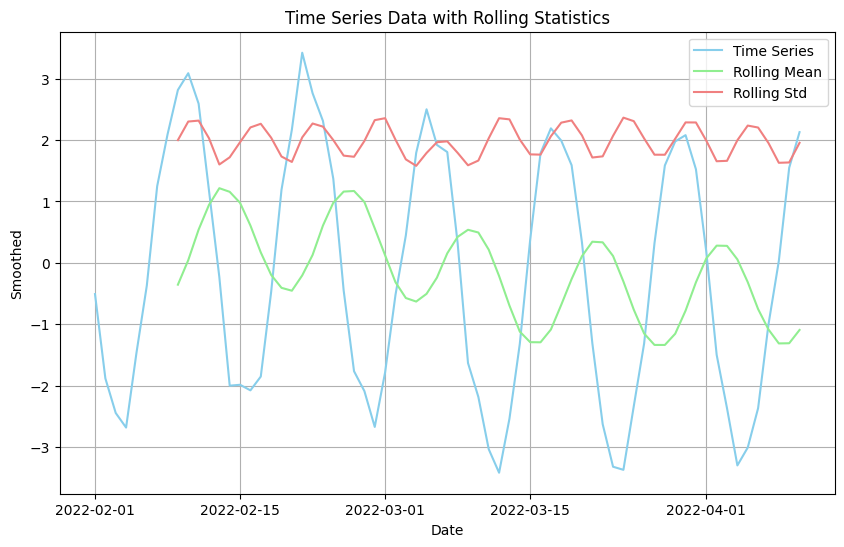

In [44]:
plot_rolling_statistics(sample_ts_df['Smoothed'],'Smoothed')

In [46]:
timeseries_stationary_check_using_ADF(sample_ts_df['Deseasonalized']) 

ADF Statistic: -1.33776190024781
p-value: 0.6117240932477728
Critical Values:
	1%: -3.5506699942762414
	5%: -2.913766394626147
	10%: -2.5946240473991997


In [47]:
timeseries_stationary_check_using_ADF(sample_ts_df['Smoothed']) 

ADF Statistic: -0.623061212304973
p-value: 0.8656855344309302
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665


We can see after removing seasonal and noise part both time series performed worse, infact they are no more stationary, so we will work with de trended timeseries.

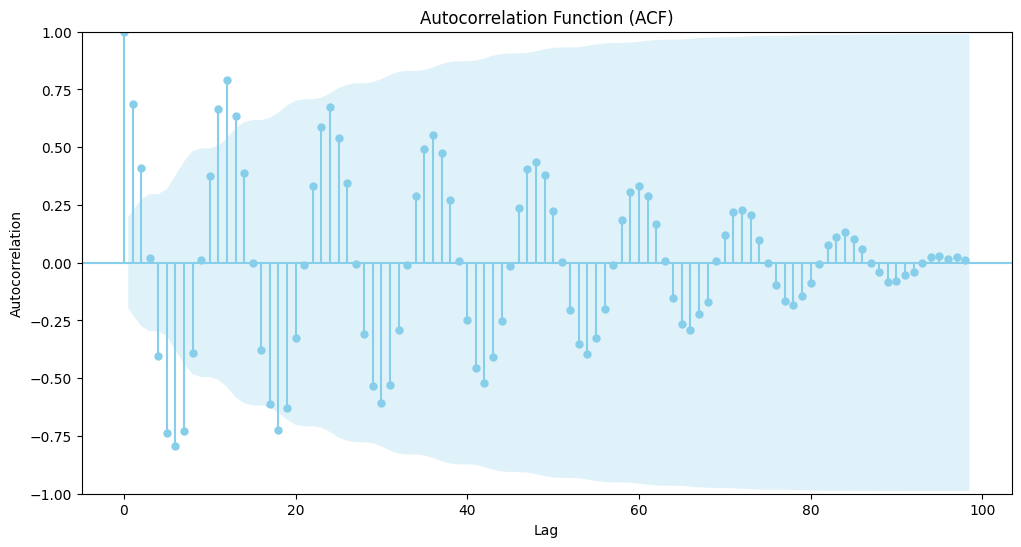

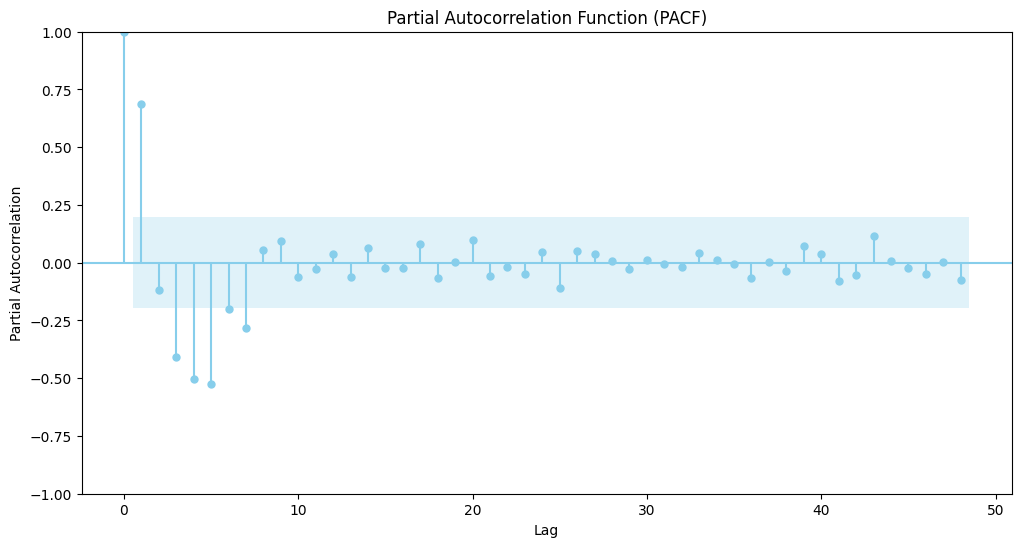

In [21]:
plot_ACF_PACF(sample_ts_df['Detrended'],98,48)

No need to look at spikes at zero, always check values starting after 0 Lag

More Details about ACF and PACF 👇

In [56]:
from IPython.display import YouTubeVideo
YouTubeVideo("ZE_WGBe0_VU", width=400)

<b>Evaluation Metric Of a model:</b> RMSE. Some advanced users might consider using information criteria like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion). These criteria penalize models for their complexity. The value of season that minimizes the chosen information criterion might be considered a good candidate.